<a href="https://colab.research.google.com/github/goodladcici/coding-test/blob/main/MFIN_7037_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MFIN 7037 Final Replication - The Dividend Month Premium, Hartzmark and Solomon (2012)


HUANG Jiayun 3035877531
\
PAN Yijie 3035914341 
\
XIE Tianci 3035942269  

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime

from tabulate import tabulate
import statsmodels.formula.api as smf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/')

In [ ]:
df1 = pd.read_csv('qt_final_data.csv')
df2 = pd.read_csv('bm.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Preparation of data

In [ ]:
df1 = df1[['PERMNO', 'date', 'SHRCD', 'EXCHCD','PAYDT','RCRDDT','DIVAMT','DISTCD',
           'PRC', 'VOL', 'RET', 'SHROUT', 'SPREAD']]
df1['date'] = df1['date'].str.replace('/','')
df1['MARKETCAP'] = df1['PRC'].apply(np.abs) * df1['SHROUT']
df1['TURNOVER'] = df1['VOL'] / df1['SHROUT']
df1['PRC'] = df1['PRC'].apply(np.abs)


df2 = df2[['permno','public_date','bm']]
df2['public_date'] = df2['public_date'].apply(lambda x: str(x))


df3 = pd.merge(df1, df2, how = 'left', left_on=['date','PERMNO'],right_on=['public_date','permno'] ).reset_index(drop = 'True')
df3 = df3[(df3['EXCHCD']==1.0) | (df3['EXCHCD']==2.0)  |(df3['EXCHCD']==3.0)]
df3 = df3[(df3['SHRCD']==10.0) | (df3['SHRCD']==11.0)]
df3['prc_lag1'] = df3.groupby('PERMNO')['PRC'].shift(1)
df3 = df3[df3['prc_lag1']>5]
df3 = df3.dropna(subset = ['prc_lag1']).reset_index(drop = 'True')
df3['year'] = df3['date'].apply(lambda x: x[:4])

def div_last_year(x):
    a = 0
    if x!=0.0000:
        a = 1
    return a


d = df3[['PERMNO', 'date','DIVAMT']]
d = d.fillna(0.0)
d['rolling12'] = d.groupby('PERMNO')['DIVAMT'].rolling(12).sum().reset_index(drop = 'True')
#d = df3.groupby(['PERMNO'])['DIVAMT'].sum().reset_index()
#d['sum_of_div_lag1'] = d.groupby('PERMNO')['DIVAMT'].shift(1)
d['rolling12_lag1'] = d.groupby('PERMNO')['rolling12'].shift(1)

d['pay_last_year'] = d['rolling12_lag1'].apply(div_last_year)


d1 = d[d['pay_last_year']==1]
d2 = d[d['pay_last_year']==0]

df4 = df3.merge(d1, how='inner',on = ['PERMNO','date'])
df4['DIVYLD'] = df4['DIVAMT_y']/df4['PRC']
df4 = df4.dropna(subset=['DISTCD'])
df4['DISTCD'] = df4['DISTCD'].apply(lambda x: str(x))
df4['usd'] = df4['DISTCD'].apply(lambda x: x[:2])
df4 = df4[df4['usd']=='12']



df5 = df3.merge(d2, how='inner',on = ['PERMNO','date'])
#df5 = df5.dropna()


def find25(x):
    x = x.dropna()
    a = sorted(x)[int(np.ceil((len(x)*1/4)))]
    return a
def find50(x):
    x = x.dropna()
    a = sorted(x)[int(np.ceil((len(x)*2/4)))]
    return a
def find75(x):
    x = x.dropna()
    a = sorted(x)[int(np.ceil((len(x)*3/4)))]
    return a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


## Table 1 Summary Statistics


## Panel A Firms with a Dividend in the Past Year

In [ ]:
t1 = [ ['Market capitalization($m)',df4['MARKETCAP'].count(),df4['MARKETCAP'].mean(),df4['MARKETCAP'].std(),find25(df4['MARKETCAP']),find50(df4['MARKETCAP']),find75(df4['MARKETCAP'])],
     ['Book-to-market',df4['bm'].count(),df4['bm'].mean(),df4['bm'].std(),find25(df4['bm']),find50(df4['bm']),find75(df4['bm'])],
     ['Turnover',df4['TURNOVER'].count(),df4['TURNOVER'].mean(),df4['TURNOVER'].std(),find25(df4['TURNOVER']),find50(df4['TURNOVER']),find75(df4['TURNOVER'])],
     ['Bid-ask spread',df4['SPREAD'].count(),df4['SPREAD'].mean(),df4['SPREAD'].std(),find25(df4['SPREAD']),find50(df4['SPREAD']),find75(df4['SPREAD'])],
     ['Dividend Yield',df4['DIVYLD'].count(),df4['DIVYLD'].mean(),df4['DIVYLD'].std(),find25(df4['DIVYLD']),find50(df4['DIVYLD']),find75(df4['DIVYLD'])],
     ['Number of firm months',len(df4),'','','','',''],
     ['Number of firms',len(list(set(df4['PERMNO']))),'','','','','']]

print(tabulate(t1, headers=['','N', 'Mean', 'Std. Dev','25%','Median','75%']))

                                N  Mean                  Std. Dev             25%                   Median               75%
-------------------------  ------  --------------------  -------------------  --------------------  -------------------  ------------------
Market capitalization($m)  566754  2814243.401562194     20097546.78334686    36267.75              143573.25            742959.375
Book-to-market             259647  1.0424909704329284    76.99521579314349    0.458                 0.727                1.083
Turnover                   526823  0.5888223726074399    1.0672970508912407   0.10647181628392484   0.2624561403508772   0.6799436023968981
Bid-ask spread              87394  1.2570615249330621    6.085833894372044    0.5                   0.75                 1.0
Dividend Yield             566754  0.010079970302678333  0.03227274235180601  0.004545454545454545  0.00796812749003984  0.0125
Number of firm months      567171
Number of firms              9801


## Panel B Firms without a Dividend in the Past Year

In [ ]:
t2 = [ ['Market capitalization($m)',df5['MARKETCAP'].count(),df5['MARKETCAP'].mean(),df5['MARKETCAP'].std(),find25(df5['MARKETCAP']),find50(df5['MARKETCAP']),find75(df5['MARKETCAP'])],
     ['Book-to-market',df5['bm'].count(),df5['bm'].mean(),df5['bm'].std(),find25(df5['bm']),find50(df5['bm']),find75(df5['bm'])],
     ['Turnover',df5['TURNOVER'].count(),df5['TURNOVER'].mean(),df5['TURNOVER'].std(),find25(df5['TURNOVER']),find50(df5['TURNOVER']),find75(df5['TURNOVER'])],
     ['Bid-ask spread',df5['SPREAD'].count(),df5['SPREAD'].mean(),df5['SPREAD'].std(),find25(df5['SPREAD']),find50(df5['SPREAD']),find75(df5['SPREAD'])],
     ['Number of firm months',len(df5),'','','','',''],
     ['Number of firms',len(list(set(df5['PERMNO']))),'','','','','']]

print(tabulate(t2, headers=['','N', 'Mean', 'Std. Dev','25%','Median','75%']))

                                N  Mean                Std. Dev            25%                Median              75%
-------------------------  ------  ------------------  ------------------  -----------------  ------------------  ------------------
Market capitalization($m)  741955  1707389.7067144478  16766307.84184619   46186.0            181466.5            707879.9
Book-to-market             454263  0.6053961119439415  0.9242606563661169  0.26               0.47                0.786
Turnover                   722420  1.6548538992899018  3.3232509680251185  0.375518868694786  0.9696381108157841  2.0556726378644186
Bid-ask spread              67533  0.9625176208668303  4.39396064088397    0.375              0.5                 1.0
Number of firm months      746910
Number of firms             12234


In [ ]:
df_fre = df4.copy()
df_fre['index'] = df_fre['DISTCD'].apply(lambda x: x[2:3])

df_fre['monthly'] = df_fre['index'].apply(lambda x: 1 if int(x)==2 else 0)
df_fre['quarterly'] = df_fre['index'].apply(lambda x: 1 if int(x)==3 else 0)
df_fre['semi'] = df_fre['index'].apply(lambda x: 1 if int(x)==4 else 0)
df_fre['annually'] = df_fre['index'].apply(lambda x: 1 if int(x)==5 else 0)
df_fre['unknown'] = df_fre['index'].apply(lambda x: 1 if int(x)<=1 else 0)

In [ ]:
total = len(df4)+len(df5)
anyfre = len(df_fre)/total
monthly = len(df_fre[df_fre['monthly'] ==1])/total
quarterly = len(df_fre[df_fre['quarterly'] ==1])/total
semi = len(df_fre[df_fre['semi'] ==1])/total
annually = len(df_fre[df_fre['annually'] ==1])/total
unknown = len(df_fre[df_fre['unknown'] ==1])/total

total_div = df_fre['DIVAMT_x'].sum()
monthly_div = df_fre[df_fre['monthly'] ==1]['DIVAMT_x'].sum()/total_div
quarterly_div = df_fre[df_fre['quarterly'] ==1]['DIVAMT_x'].sum()/total_div
semi_div = df_fre[df_fre['semi'] ==1]['DIVAMT_x'].sum()/total_div
annually_div = df_fre[df_fre['annually'] ==1]['DIVAMT_x'].sum()/total_div
unknown_div = df_fre[df_fre['unknown'] ==1]['DIVAMT_x'].sum()/total_div

## Panel C Distributions of Dividend Frequencies

In [ ]:
t3 = [['Any Frequency',anyfre,''],
      ['Monthly', monthly, monthly_div],
      ['Quarterly', quarterly, quarterly_div],
      ['Semi-Annually', semi, semi_div],
      ['Annually', annually, annually_div],
      ['Unknown Frequency', unknown, unknown_div]]

print(tabulate(t3, headers=['Dividend Frequency','Pct of Firm/Months with Div in the last yr', 'Pct of Div Observation']))

Dividend Frequency      Pct of Firm/Months with Div in the last yr  Pct of Div Observation
--------------------  --------------------------------------------  ------------------------
Any Frequency                                           0.43161
Monthly                                                 0.0031231   0.004468477151405742
Quarterly                                               0.366926    0.7633702821700987
Semi-Annually                                           0.00632153  0.010921838722132943
Annually                                                0.00182181  0.004749345073605203
Unknown Frequency                                       0.0314501   0.11318945400569931


# Table 2 Returns and the Probability of Current Dividend Payment, Sorted By Timing of Past

In [ ]:
# Get data of DISTCD and RET after dividend
df_1=df3[['PERMNO', 'date', 'DISTCD','PAYDT','DIVAMT', 'PRC', 'RET']]
def Ret(x):
    try:
        return float(x)
    except:
        return None

df_1['RET'] = df_1['RET'].apply(Ret)
for i in range(1,13):
    df_1[str(i)+'mths_DISTCD'] = df_1['DISTCD'].shift(-i)
    df_1[str(i)+'mths_RET'] = df_1['RET'].shift(-i)
df_1 = df_1.dropna(subset = ['DISTCD'])

In [ ]:
# Totla number of dividends
K = len(df_1)

# Define function for counting Quaterly dividend
def Qcounter(x):
  if x[2]== '3' :    
    return 1
  else:
    return 0 

In [ ]:
# Calculation
M=[]
S=[]
PA=[]
PQ=[]
for i in range(1,13):
    M.append(df_1[str(i)+'mths_RET'].dropna().mean()*100)
    S.append(df_1[str(i)+'mths_RET'].dropna().std()*100)
    PA.append(len(df_1[str(i)+'mths_DISTCD'].dropna())/K)
    PQ.append(sum(df_1[str(i)+'mths_DISTCD'].dropna().apply(str).apply(Qcounter))/K)

## Panel A Raw returns and dividend payments

In [ ]:
t2a = [ [" ", "Mean return", "Std. Deviation", "All Dividends", "Quarterly Dividends"],
     ["1",M[0],S[0],PA[0],PQ[0]],
     ["2",M[1],S[1],PA[1],PQ[1]],
     ["3",M[2],S[2],PA[2],PQ[2]],
     ["4",M[3],S[3],PA[3],PQ[3]],
     ["5",M[4],S[4],PA[4],PQ[4]],
     ["6",M[5],S[5],PA[5],PQ[5]],
     ["7",M[6],S[6],PA[6],PQ[6]],
     ["8",M[7],S[7],PA[7],PQ[7]],
     ["9",M[8],S[8],PA[8],PQ[8]],
     ["10",M[9],S[9],PA[9],PQ[9]],
     ["11",M[10],S[10],PA[10],PQ[10]],
     ["12",M[11],S[11],PA[11],PQ[11]]]

print(tabulate(t2a, headers=["Months Since Dividend","Returns in Current Month","Probability of Dividend", " "]))

    Months Since Dividend    Returns in Current Month    Probability of Dividend
--  -----------------------  --------------------------  -------------------------  -------------------
    Mean return              Std. Deviation              All Dividends              Quarterly Dividends
1   1.1293719892917007       10.123274918117296          0.0842421560016874         0.04732332418171382
2   1.1610724479330066       10.188892278355517          0.08797138332376678        0.06082081036783978
3   1.3485685235932048       10.066229478046775          0.7598045656669041         0.6824814489526352
4   1.0557535868750256       10.190234596555104          0.15625410612651364        0.11251996874157164
5   1.1421123919948433       10.286743375485235          0.10977621178276775        0.07758763770651655
6   1.3283517294115148       10.147464919481909          0.7174068644061936         0.6376010539346201
7   1.0869591426275336       10.294301910185093          0.17660839136658807        0.128

# Panel B Returns Based on Predicted Dividends

In [ ]:
ff = pd.read_csv('ff.csv')
ff = ff.dropna().reset_index(drop = 'True')


fr = df4.copy()########################
fr['div_lag1'] = fr.groupby('PERMNO')['DIVAMT_x'].shift(1).fillna(0.0)
fr['div_lag2'] = fr.groupby('PERMNO')['DIVAMT_x'].shift(2).fillna(0.0)
fr['div_lag3'] = fr.groupby('PERMNO')['DIVAMT_x'].shift(3).fillna(0.0)
fr['div_lag4'] = fr.groupby('PERMNO')['DIVAMT_x'].shift(4).fillna(0.0)
fr['div_lag5'] = fr.groupby('PERMNO')['DIVAMT_x'].shift(5).fillna(0.0)
fr['div_lag6'] = fr.groupby('PERMNO')['DIVAMT_x'].shift(6).fillna(0.0)
fr['div_lag7'] = fr.groupby('PERMNO')['DIVAMT_x'].shift(7).fillna(0.0)
fr['div_lag8'] = fr.groupby('PERMNO')['DIVAMT_x'].shift(8).fillna(0.0)
fr['div_lag9'] = fr.groupby('PERMNO')['DIVAMT_x'].shift(9).fillna(0.0)
fr['div_lag10'] = fr.groupby('PERMNO')['DIVAMT_x'].shift(10).fillna(0.0)
fr['div_lag11'] = fr.groupby('PERMNO')['DIVAMT_x'].shift(11).fillna(0.0)
fr['div_lag12'] = fr.groupby('PERMNO')['DIVAMT_x'].shift(12).fillna(0.0)


long1 = fr[(fr['div_lag3']>0) | (fr['div_lag6']>0)| (fr['div_lag12']>0)].reset_index(drop='True')
short1 = fr[(fr['div_lag1']>0) | (fr['div_lag4']>0)| (fr['div_lag7']>0)| (fr['div_lag10']>0)].reset_index(drop='True')
short2 = fr[(fr['div_lag3']==0) & (fr['div_lag6']==0)& (fr['div_lag12']==0)].reset_index(drop='True')
short3 = pd.concat([short2,df5],ignore_index='True')


long = long1.dropna(subset=['RET'])
long = long[long['RET']!='C']
long['ret'] = long['RET'].apply(float)
long['mcap_lag1'] = long.groupby('PERMNO')['MARKETCAP'].shift(1)
long = long.dropna(subset=['mcap_lag1'])

short1 = short1.dropna(subset=['RET'])
short1= short1[short1['RET']!='C']
short1['ret'] = short1['RET'].apply(float)
short1['mcap_lag1'] = short1.groupby('PERMNO')['MARKETCAP'].shift(1)
short1 = short1.dropna(subset=['mcap_lag1'])

short2 = short2.dropna(subset=['RET'])
short2= short2[short2['RET']!='C']
short2['ret'] = short2['RET'].apply(float)
short2['mcap_lag1'] = short2.groupby('PERMNO')['MARKETCAP'].shift(1)
short2 = short2.dropna(subset=['mcap_lag1'])

short3 = short3.dropna(subset=['RET'])
short3 = short3[short3['RET']!='C']
short3['ret'] = short3['RET'].apply(float)
short3['mcap_lag1'] = short3.groupby('PERMNO')['MARKETCAP'].shift(1)
short3 = short3.dropna(subset=['mcap_lag1'])

portfolio_long = (
    long
    .groupby('date')
    .apply(
        lambda g: pd.Series({
            'portfolio_ew': g['ret'].mean(),
            'portfolio_vw': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )).reset_index()

portfolio_short1 = (
    short1
    .groupby('date')
    .apply(
        lambda g: pd.Series({
            'portfolio_ew': g['ret'].mean(),
            'portfolio_vw': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )).reset_index()

portfolio_short2 = (
    short2
    .groupby('date')
    .apply(
        lambda g: pd.Series({
            'portfolio_ew': g['ret'].mean(),
            'portfolio_vw': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )).reset_index()

portfolio_short3 = (
    short3
    .groupby('date')
    .apply(
        lambda g: pd.Series({
            'portfolio_ew': g['ret'].mean(),
            'portfolio_vw': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )).reset_index()



In [ ]:
temp = fr.iloc[:,-12:]
last_month = []

for i in range(len(fr)):
    for j in range(12):
        if temp.iloc[i,j]!=0.0:
            a = j+1
        else:
            a = 13
    last_month.append(a)

In [ ]:

fr['last'] = last_month
fr = fr.dropna(subset=['DISTCD'])
fr['freq'] = fr['DISTCD'].apply(lambda x:str(x)[2])

def freq(x):
    if x == '4':
        a = 6
    elif x == '5':
        a = 12
    else:
        a = 3
    return a

fr['l'] = fr['freq'].apply(freq)
fr= fr[fr['freq']=='3']

long11 = fr[fr['l']==fr['last']]
short11 = fr[fr['l']!=fr['last']]

long11 = long11.dropna(subset=['RET'])
long11 = long11[long11['RET']!='C']
long11['ret'] = long11['RET'].apply(float)
long11['mcap_lag1'] = long11.groupby('PERMNO')['MARKETCAP'].shift(1)
long11 = long11.dropna(subset=['mcap_lag1'])

short11 = short11.dropna(subset=['RET'])
short11= short11[short11['RET']!='C']
short11['ret'] = short11['RET'].apply(float)
short11['mcap_lag1'] = short11.groupby('PERMNO')['MARKETCAP'].shift(1)
short11 = short11.dropna(subset=['mcap_lag1'])





In [ ]:
portfolio_long11 = (
    long11
    .apply(
        lambda g: pd.Series({
            'portfolio_ew': g['ret'].mean(),
            'portfolio_vw': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )).reset_index()


portfolio_short11 = (
    short11
    .groupby('date')
    .apply(
        lambda g: pd.Series({
            'portfolio_ew': g['ret'].mean(),
            'portfolio_vw': (g['ret'] * g['mcap_lag1']).sum() / g['mcap_lag1'].sum()
        })
    )).reset_index()



In [ ]:
fr1 = df5.copy()
fr1 = fr1[fr1['RET']!='C']
fr1['RET'] = fr1['RET'].apply(float)
fr1 = fr1.groupby('date')['RET'].mean().reset_index()

In [ ]:
def findn(x,n):
    x = x.dropna()
    a = sorted(x)[int(np.ceil((len(x)*n/100)))]
    return a


aaa = [portfolio_long['portfolio_ew'].mean()\
      ,portfolio_long['portfolio_ew'].std()\
          ,(portfolio_long['portfolio_ew'].mean()/portfolio_long['portfolio_ew'].std())
      ,findn(portfolio_long['portfolio_ew'],1)\
      ,findn(portfolio_long['portfolio_ew'],5)\
          ,findn(portfolio_long['portfolio_ew'],25)\
              ,findn(portfolio_long['portfolio_ew'],50)\
                  ,findn(portfolio_long['portfolio_ew'],75)\
                      ,findn(portfolio_long['portfolio_ew'],95)\
                          ,findn(portfolio_long['portfolio_ew'],99)]

bbb = [portfolio_short1['portfolio_ew'].mean()\
      ,portfolio_short1['portfolio_ew'].std()\
          ,(portfolio_short1['portfolio_ew'].mean()/portfolio_short1['portfolio_ew'].std())
      ,findn(portfolio_short1['portfolio_ew'],1)\
      ,findn(portfolio_short1['portfolio_ew'],5)\
          ,findn(portfolio_short1['portfolio_ew'],25)\
              ,findn(portfolio_short1['portfolio_ew'],50)\
                  ,findn(portfolio_short1['portfolio_ew'],75)\
                      ,findn(portfolio_short1['portfolio_ew'],95)\
                          ,findn(portfolio_short1['portfolio_ew'],99)]
ccc = [fr1['RET'].mean()\
      ,fr1['RET'].std()\
          ,(fr1['RET'].mean()/fr1['RET'].std())
      ,findn(fr1['RET'],1)\
      ,findn(fr1['RET'],5)\
          ,findn(fr1['RET'],25)\
              ,findn(fr1['RET'],50)\
                  ,findn(fr1['RET'],75)\
                      ,findn(fr1['RET'],95)\
                          ,findn(fr1['RET'],99)]

ddd= [(portfolio_long['portfolio_ew']-portfolio_short1['portfolio_ew']).mean()\
      ,(portfolio_long['portfolio_ew']-portfolio_short1['portfolio_ew']).std()\
          ,((portfolio_long['portfolio_ew']-portfolio_short1['portfolio_ew']).mean()/(portfolio_long['portfolio_ew']-portfolio_short1['portfolio_ew']).std())
      ,findn((portfolio_long['portfolio_ew']-portfolio_short1['portfolio_ew']),1)\
      ,findn((portfolio_long['portfolio_ew']-portfolio_short1['portfolio_ew']),5)\
          ,findn((portfolio_long['portfolio_ew']-portfolio_short1['portfolio_ew']),25)\
              ,findn((portfolio_long['portfolio_ew']-portfolio_short1['portfolio_ew']),50)\
                  ,findn((portfolio_long['portfolio_ew']-portfolio_short1['portfolio_ew']),75)\
                      ,findn((portfolio_long['portfolio_ew']-portfolio_short1['portfolio_ew']),95)\
                          ,findn((portfolio_long['portfolio_ew']-portfolio_short1['portfolio_ew']),99)]


eee = [(portfolio_long['portfolio_ew']-fr1['RET']).mean()\
      ,(portfolio_long['portfolio_ew']-fr1['RET']).std()\
          ,((portfolio_long['portfolio_ew']-fr1['RET']).mean()/(portfolio_long['portfolio_ew']-fr1['RET']).std())
      ,findn((portfolio_long['portfolio_ew']-fr1['RET']),1)\
      ,findn((portfolio_long['portfolio_ew']-fr1['RET']),5)\
          ,findn((portfolio_long['portfolio_ew']-fr1['RET']),25)\
              ,findn((portfolio_long['portfolio_ew']-fr1['RET']),50)\
                  ,findn((portfolio_long['portfolio_ew']-fr1['RET']),75)\
                      ,findn((portfolio_long['portfolio_ew']-fr1['RET']),95)\
                          ,findn((portfolio_long['portfolio_ew']-fr1['RET']),99)]

In [ ]:
t2b = [
     ['[1] Predicted Dividend Month'] + aaa\
     ,['[2] All Other Companies with a Dividend in the Last 12 Months'] + bbb\
     ,['[3] All Other Companies with NO Dividend in the Last 12 Months'] + ccc\
     ,['Portfolio Long [1] and Short [2]']+ddd\
     ,['Portfolio Long [1] and Short [3]']+eee]
     
print(tabulate(t2b, headers=['','mean','standard deviation','sharpe ratio','1%','5%','25%','medium','75%','95%','99%']))

                                                                        mean    standard deviation    sharpe ratio         1%          5%          25%       medium        75%        95%       99%
--------------------------------------------------------------  ------------  --------------------  --------------  ---------  ----------  -----------  -----------  ---------  ---------  --------
[1] Predicted Dividend Month                                     0.0160385               0.051641       0.310576    -0.136138  -0.0622993  -0.00939031   0.0187584   0.0437373  0.0862281  0.150871
[2] All Other Companies with a Dividend in the Last 12 Months    0.0161289               0.0516988      0.311977    -0.13708   -0.0625338  -0.00942162   0.0186745   0.043641   0.0844628  0.150957
[3] All Other Companies with NO Dividend in the Last 12 Months   0.0100518               0.0848467      0.118471    -0.225622  -0.124677   -0.0322596    0.0114899   0.0543289  0.13183    0.211622
Portfolio Long [1] a

In [ ]:
portfolio_long['date'] = portfolio_long['date'].apply(int)
portfolio_short1['date']= portfolio_short1['date'].apply(int)
portfolio_short2['date']= portfolio_short2['date'].apply(int)
portfolio_short3['date']= portfolio_short3['date'].apply(int)

ff['dateff'] = ff['dateff'].apply(int)
portfolio_long = portfolio_long.merge(ff,how='inner',left_on='date',right_on='dateff')
portfolio_short1= portfolio_short1.merge(ff,how='inner',left_on='date',right_on='dateff')
portfolio_short2= portfolio_short2.merge(ff,how='inner',left_on='date',right_on='dateff')
portfolio_short3= portfolio_short3.merge(ff,how='inner',left_on='date',right_on='dateff')



portfolio_long = (
    portfolio_long
    .groupby('date')
    .apply(
        lambda g: pd.Series({
            'mktrf': (g['mktrf']+1).prod()-1,
            'smb': (g['smb']+1).prod()-1,
            'hml': (g['hml']+1).prod()-1,
            'umd': (g['umd']+1).prod()-1,
            'portfolio_ew': (g['portfolio_ew']+1).prod()-1,
            'portfolio_vw': (g['portfolio_vw']+1).prod()-1
        })
    )
)

portfolio_short1 = (
    portfolio_short1
    .groupby('date')
    .apply(
        lambda g: pd.Series({
            'mktrf': (g['mktrf']+1).prod()-1,
            'smb': (g['smb']+1).prod()-1,
            'hml': (g['hml']+1).prod()-1,
            'umd': (g['umd']+1).prod()-1,
            'portfolio_ew': (g['portfolio_ew']+1).prod()-1,
            'portfolio_vw': (g['portfolio_vw']+1).prod()-1
        })
    )
)

portfolio_short2 = (
    portfolio_short2
    .groupby('date')
    .apply(
        lambda g: pd.Series({
            'mktrf': (g['mktrf']+1).prod()-1,
            'smb': (g['smb']+1).prod()-1,
            'hml': (g['hml']+1).prod()-1,
            'umd': (g['umd']+1).prod()-1,
            'portfolio_ew': (g['portfolio_ew']+1).prod()-1,
            'portfolio_vw': (g['portfolio_vw']+1).prod()-1
        })
    )
)

portfolio_short3 = (
    portfolio_short3
    .groupby('date')
    .apply(
        lambda g: pd.Series({
            'mktrf': (g['mktrf']+1).prod()-1,
            'smb': (g['smb']+1).prod()-1,
            'hml': (g['hml']+1).prod()-1,
            'umd': (g['umd']+1).prod()-1,
            'portfolio_ew': (g['portfolio_ew']+1).prod()-1,
            'portfolio_vw': (g['portfolio_vw']+1).prod()-1
        })
    )
)


## Table 3 Abnormal Returns in Predicted Dividend Months

# Panel A Four Factor Alphas For Difference Portfolios Based on Predicted Dividends

In [ ]:
t3a = [ ['long','0.0093***', '0.0093***', '0.0093***', '0.0067***','0.0067***','0.0067***'],
     ['','(19.206)','(19.206)','(19.206)','(16.468)','(16.468)','(16.468)'],
     ["short",'0.0001','0.0093***','0.0127***','0.0001', '0.0067***','0.0118***'],
     ["",'(0.169)','(19.412)','(8.342)','(0.169)', '(16.584)', '(6.684)'],
     ["difference",0.0092,0,-0.1177,0.0066,0,-0.1113]]

print(tabulate(t3a, headers=['','equal weight', '','','value weight','','']))

            equal weight                          value weight
----------  --------------  ---------  ---------  --------------  ---------  ---------
long        0.0093***       0.0093***  0.0093***  0.0067***       0.0067***  0.0067***
            (19.206)        (19.206)   (19.206)   (16.468)        (16.468)   (16.468)
short       0.0001          0.0093***  0.0127***  0.0001          0.0067***  0.0118***
            (0.169)         (19.412)   (8.342)    (0.169)         (16.584)   (6.684)
difference  0.0092          0          -0.1177    0.0066          0          -0.1113


Panel B Factor Loadings from Fama French 4 Factor Difference Portfolios

## Figure 1

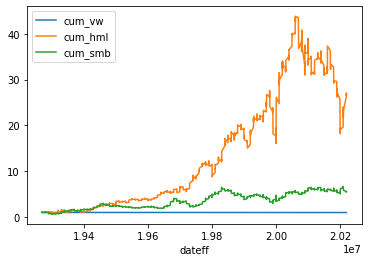

In [ ]:
portfolio = pd.merge(portfolio_long,portfolio_short1,on='date',how='outer',suffixes=['_long','_short'])
portfolio = portfolio.fillna(0.0).sort_values(by = 'date')
portfolio['ret_ew'] = portfolio['portfolio_ew_long'] - portfolio['portfolio_ew_short']
portfolio['ret_vw'] = portfolio['portfolio_vw_long'] - portfolio['portfolio_vw_short']
portfolio['cum_ew'] = (portfolio['ret_ew'] + 1).cumprod() 
portfolio['cum_vw'] = (portfolio['ret_vw'] + 1).cumprod() 

ff['dateff'] = ff['dateff'].apply(int)
portfolio = portfolio.merge(ff,left_on='date',right_on='dateff',how = 'left')

portfolio['cum_hml'] = (portfolio['hml'] + 1).cumprod() 
portfolio['cum_smb'] = (portfolio['smb'] + 1).cumprod() 

portfolio.plot('dateff',['cum_vw','cum_hml','cum_smb'])